### References:
- Tensorflow Swift - [link](https://www.tensorflow.org/swift)
- PythonKit - [Numy conversion](https://github.com/pvieito/PythonKit/blob/master/Tests/PythonKitTests/NumpyConversionTests.swift)
- Swfit Optionals - [link](https://medium.com/@agoiabeladeyemi/optionals-in-swift-2b141f12f870)
- Random numbers in Swift - [link](https://learnappmaking.com/random-numbers-swift/)
- Functions in Swift - [link](https://www.programiz.com/swift-programming/function-parameter-return-values)
- Assertions in Swift - [link](https://blog.krzyzanowskim.com/2015/03/09/swift-asserts-the-missing-manual/)
- Swift by example - [link](http://brettbukowski.github.io/SwiftExamples/)

### Imports

Import some useful python libraries

In [0]:
import Python
let request = Python.import("urllib.request")
let pickle = Python.import("pickle")
let gzip = Python.import("gzip")
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

plotting

In [0]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [0]:
import TensorFlow

Swift stdlib imports

### MNIST
Download the dataset

In [0]:
let result = request.urlretrieve(
    "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz",
    "mnist.pkl.gz")
let filename = result[0]; filename

mnist.pkl.gz


In [0]:
let mnist = pickle.load(gzip.open(filename), encoding:"latin-1")
// read train, validation and test datasets
let train_mnist = mnist[0]
let valid_mnist = mnist[1]
let test_mnist = mnist[2]

Read the arrays into Tensorflow tensors

In [0]:
train_mnist

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8]))


In [0]:
func unsequeeze(_ array: PythonObject) -> PythonObject {
    return np.expand_dims(array, axis:-1).astype(np.float32)
}

In [0]:
// read training tuple into separate variables
let pyobj_train_x = train_mnist[0]
let pyobj_train_y = unsequeeze(train_mnist[1]) // expand dimension
// read validation tuple into separate variables
let pyobj_valid_x = valid_mnist[0]
let pyobj_valid_y = unsequeeze(valid_mnist[1]) // expand dimension
// read test tuple into separate variables
let pyobj_test_x = test_mnist[0]
let pyobj_test_y = unsequeeze(test_mnist[1]) // expand dimension

In [0]:
pyobj_train_y.shape

(50000, 1)


Training data

In [0]:
// read tensorflow arrays into Tensors
let X_train = Tensor<Float32>(numpy: pyobj_train_x)! // ! to unwrap optionals
let y_train = Tensor<Float32>(numpy: pyobj_train_y)! // ! to unwrap optionals

Validation data

In [0]:
// read tensorflow arrays into Tensors
let X_valid = Tensor<Float32>(numpy: pyobj_valid_x)! // ! to unwrap optionals
let y_valid = Tensor<Float32>(numpy: pyobj_valid_y)! // ! to unwrap optionals

Test data

In [0]:
// read tensorflow arrays into Tensors
let X_test = Tensor<Float32>(numpy: pyobj_test_x)! // ! to unwrap optionals
let y_test = Tensor<Float32>(numpy: pyobj_test_y)! // ! to unwrap optionals

In [0]:
print("\(X_train.shape) \(y_train.shape)") // string interpolation

TensorShape(dimensions: [50000, 784]) TensorShape(dimensions: [50000, 1])


In [0]:
X_train.shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 50000
    - 1 : 784


In [0]:
y_train.shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 50000
    - 1 : 1


### Plotting

In [0]:
let sample1 = X_train[0].reshaped(to: [28, 28]).array // ShapedArray

In [0]:
let sample2 = X_train[0].reshaped(to: [28, 28]).scalars // simple array

In [0]:
let sample3 = X_train[0].reshaped(to: [28, 28]).makeNumpyArray()
sample3.shape

(28, 28)


transform the scalars into a 28 by 28 image and plot it

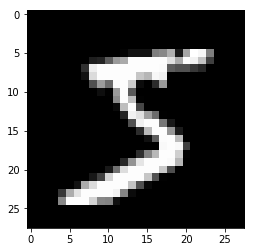

None


In [0]:
plt.imshow(np.reshape(sample2, newshape:[28, 28]), cmap:"gray")
plt.show()

### Data

#### Normalization

In [0]:
// normalization helper functions
func mean(t: Tensor<Float32>) -> Float32 {
    let res_tensor = t.mean()
    return res_tensor.scalar!
}

func stddev(t: Tensor<Float32>) -> Float32 {
    let mean = t.mean()
    let res_tensor = sqrt(t.squared().mean() - mean*mean)
    return res_tensor.scalar!
}

In [0]:
// test helper functions
func test_near_zero(_ val: Float32, _ msg: String) -> Void {
    assert(val < 1e-3, msg)
}

In [0]:
let m = mean(t: X_train)
let s = stddev(t: X_train)

In [0]:
let Xtrain_normalized = (X_train - m)/s
let Xvalid_normalized = (X_valid - m)/s
let Xtest_normalized = (X_test - m)/s

Check that X is really normalized (mean 0 and standard deviation of 1)

In [0]:
test_near_zero(mean(t: Xtrain_normalized), "Mean not close to 0")
test_near_zero(abs(stddev(t: Xtrain_normalized) - 1), "Standard deviation not close to 1")

In [0]:
print("mean=\(mean(t: Xtrain_normalized)), stddev=\(stddev(t: Xtrain_normalized))")

mean=1.6934141e-08, stddev=1.0000006


### Initial model
Let's start with an initial FNN with one hiden layer, and instead of number of classes output to which would apply a categorical cross entropy loss function. To simplify the architecture we use root squared mean error and thus the final output would be one value.

A model contains a set of parameters initialized randomly, then use the gradients to gradually update them through SGD.

In [0]:
let nh: Int32 = 50 // number of hidden units
let nc: Int32 = 10 // number of classes
let fs: Int32 = X_train.shape[1] // input features size

simple linear model

In [0]:
func randn(_ ni: Int32, _ no: Int32) -> Tensor<Float32> {
    let np_array = np.random.randn(ni, no).astype(np.float32)
    let np_array_normalized = (np_array - np_array.mean()) / np_array.std()
    let tensor = Tensor<Float32>(numpy: np_array_normalized)
    return tensor!
}

func kaiming_init(_ ni: Int32, _ no: Int32) -> Tensor<Float32> {
    let np_array = np.random.randn(ni, no).astype(np.float32)
    let tensor = Tensor<Float32>(numpy: np_array)
    return tensor! * sqrt(2.0 / Float32(ni)) // kaiming
}

func zeros(_ n: Int32) -> Tensor<Float32> {
    let np_array = np.zeros(n).astype(np.float32)
    let tensor = Tensor<Float32>(numpy: np_array)
    return tensor!
}

In [0]:
var w1 = randn(fs, nh)
var b1 = zeros(nh)
var w2 = randn(nh, 1)
var b2 = zeros(nh)

matrix multiplication is a foundational operation in NN, thus it has to be very fast

In [0]:
test_near_zero(mean(t: w1), "Mean not close to 0")
test_near_zero(abs(stddev(t: w1) - 1), "Standard deviation not close to 1")

In [0]:
print("\(mean(t: w1)) \(stddev(t: w1))")

-3.1140386e-09 1.0


define functions for NN layers

In [0]:
// NN layers grouped in one class
class F {
    static func linear(_ x: Tensor<Float32>, _ w: Tensor<Float32>, _ b: Tensor<Float32>) -> Tensor<Float32> {
        return matmul(x, w) + b
    }

    static func relu(_ x: Tensor<Float32>) -> Tensor<Float32> {
        return max(x, 0) - 0.5 // to make this layer output mean at 0.
    }
}

In [0]:
let o1 = F.linear(X_train, w1, b1)

In [0]:
print("\(mean(t: o1)) \(stddev(t: o1))")

0.5935556 9.077584


Now this is a problem, we would wanted to have the output of the liear layer to be have a variance onf 1 just as is the input of this layer, this to avoind gradients vanishing/explosion when using deep NN.

This is where Kaiming initialization comes to rescue. A simplified version of it consists of dividing the parameters by square root of the number of input units. The 2 is used to make the .

In [0]:
let w1_kaiming = kaiming_init(fs, nh)
let o1_kaiming = F.relu(F.linear(Xtrain_normalized, w1_kaiming, b1))
print("\(mean(t: o1_kaiming)) \(stddev(t: o1_kaiming))")

0.06218194 0.838228


Now as we can construct a simple model and do a forward pass

In [0]:
class Model {
    var w1: Tensor<Float32>
    var b1: Tensor<Float32>
    var w2: Tensor<Float32>
    var b2: Tensor<Float32>
    
    init(_ fs: Int32, _ nh: Int32) {
        self.w1 = kaiming_init(fs, nh)
        self.b1 = zeros(nh)
        self.w2 = kaiming_init(nh, 1)
        self.b2 = zeros(1)
    }
    
    func forward(_ x: Tensor<Float32>) -> Tensor<Float32> {
        let l1 = F.linear(x, self.w1, self.b1)
        let l2 = F.relu(l1)
        let l3 = F.linear(l2, self.w2, self.b2)
        return l3
    }
}

In [0]:
let m = Model(fs, nh)

### Forward

In [0]:
let y_hat = m.forward(X_normalized)

In [0]:
y_hat[10]

[-2.0750358]


loss function MSE

In [0]:
func mse(_ t1: Tensor<Float32>, _ t2: Tensor<Float32>) -> Float32 {
    let res_tensor = (t1 - t2).squared().mean()
    return res_tensor.scalar!
}

In [0]:
mse(y_hat, y_train)

22.626156


#### Backward

Chain Rule: 
$$\hat{y} = linear_2(relu(linear_1(X)))$$
$$loss = mse(\hat{y}, y)$$
According to the Chain rule if $y=f(u)$ and $u=g(x)$ then the gradient of $y$ to the respect of $x$ is the multiplication of the gradient of  $y$ to  $u$ by the gradient of  $u$ by  $x$. i.e.
$$\frac{dy}{dx} = \frac{dy}{du} . \frac{du}{dx}$$

#### Gradients
The gradient of a function (i.e. the output of $f(x)$) with respect to its input (i.e. the output of previous layer) $x$.

Gradient of MSE loss function $mse(\hat{y}, y) = \frac{1}{m} *\sum_{i=1}^{m}  (\hat{y}_i - y_i)^2$  is $grad_{mse} = 2 * \frac{1}{m} *  \sum_{i=1}^{m}  (\hat{y}_i - y_i)$.

In [0]:
func grad_mse(_ input: Tensor<Float32>, _ output: Tensor<Float32>)
-> Tensor<Float32> {
    let m = Float32(X_train.shape[0])
    return Float32(2.0) * (1/m) * (input - output)
}

Gradient of ReLU activation fuction $ReLU(x) = max(x, 0)$ is $grad_{ReLU} = \left \{ \begin{array}{ll}
1 & x>0 \\
0 & x \leq 0
\end{array}
\right .$

In [0]:
func grad_relu(_ input: Tensor<Float32>, _ output: Tensor<Float32>, _ output_grad: Tensor<Float32>)
-> Tensor<Float32> {
    return min(ceil(max(input, 0.0)), 1) * output_grad
}

Gradient of matrix product is a matrix product by the transpose (check Matrix Calculus resource).

Recall $linear(x) = x * w + b$ thus the gradients respectively to each element are $$\left \{
  \begin{array}{ll}
    \frac{d}{dx} linear(x)  & = w \\
    \frac{d}{dw} linear(x) & = x \\
    \frac{d}{db} linear(x)  & = 1
  \end{array}
\right .$$

In [0]:
func grad_linear(_ input: Tensor<Float32>, _ output: Tensor<Float32>, _ output_grad: Tensor<Float32>,
                 _ weights: Tensor<Float32>, _ bias: Tensor<Float32>
                )
-> (Tensor<Float32>, Tensor<Float32>, Tensor<Float32>)
{
    let input_grad   = (output_grad * weights.transposed())
    let weights_grad = (output_grad * input).sum(squeezingAxes: [0])
    let bias_grad    = (output_grad * 1.0).sum(squeezingAxes: [0])
    return (input_grad, weights_grad, bias_grad)
}

Forward combined with backward pass

In [0]:
// forward pass
let l1 = F.linear(X_normalized, w1, b1)
let l2 = F.relu(l1)
let y_hat = F.linear(l2, w2, b2)
let loss = mse(y_hat, y_train)
// backward pass
let y_hat_grad = grad_mse(y_hat, y_train)
let (l2_grad,w2_grad, b2_grad) = grad_linear(l2, y_hat, y_hat_grad, w2, b2)
let l1_grad = grad_relu(l1, l2, l2_grad)

In [0]:
let (X_grad,w1_grad, b1_grad) = grad_linear(X_normalized, l1, l1_grad, w1, b1)

Fatal error: Incompatible shapes: [50000,50] vs. [50,784]: file /swift-base/swift/stdlib/public/TensorFlow/CompilerRuntime.swift, line 2094
Current stack trace:
0    libswiftCore.so                    0x00007f6a6c109f40 _swift_stdlib_reportFatalErrorInFile + 115
1    libswiftCore.so                    0x00007f6a6c0523dc <unavailable> + 3003356
2    libswiftCore.so                    0x00007f6a6c0524ce <unavailable> + 3003598
3    libswiftCore.so                    0x00007f6a6be99e12 <unavailable> + 1199634
4    libswiftCore.so                    0x00007f6a6c01c6b2 <unavailable> + 2782898
5    libswiftCore.so                    0x00007f6a6be99259 <unavailable> + 1196633
6    libswiftTensorFlow.so              0x00007f6a572c6ad2 <unavailable> + 441042
7    libswiftTensorFlow.so              0x00007f6a572c5230 checkOk(_:file:line:) + 491
8    libswiftTensorFlow.so              0x00007f6a572e8270 _TFCCheckOk(_:) + 81
9    libswiftTensorFlow.so              0x00007f6a572e8260 _swift_tfc_Che

: ignored